# TODO: Title

This notebook lists all the steps that you need to complete the complete this project. You will need to complete all the TODOs in this notebook as well as in the README and the two python scripts included with the starter code.


**TODO**: Give a helpful introduction to what this notebook is for. Remember that comments, explanations and good documentation make your project informative and professional.

**Note:** This notebook has a bunch of code and markdown cells with TODOs that you have to complete. These are meant to be helpful guidelines for you to finish your project while meeting the requirements in the project rubrics. Feel free to change the order of these the TODO's and use more than one TODO code cell to do all your tasks.

In [1]:
# TODO: Install any packages that you might need
# For instance, you will need the smdebug package
!pip install smdebug

  Using cached smdebug-1.0.34-py2.py3-none-any.whl.metadata (1.8 kB)
  Using cached protobuf-3.20.3-py2.py3-none-any.whl.metadata (720 bytes)
  Using cached pyinstrument-3.4.2-py2.py3-none-any.whl.metadata (22 kB)
  Using cached pyinstrument_cext-0.2.4-cp311-cp311-linux_x86_64.whl
Using cached smdebug-1.0.34-py2.py3-none-any.whl (280 kB)
Using cached pyinstrument-3.4.2-py2.py3-none-any.whl (83 kB)
Using cached protobuf-3.20.3-py2.py3-none-any.whl (162 kB)
  Attempting uninstall: protobuf
    Found existing installation: protobuf 4.25.3
    Uninstalling protobuf-4.25.3:
      Successfully uninstalled protobuf-4.25.3


In [2]:
# TODO: Import any packages that you might need
# For instance you will need Boto3 and Sagemaker
import sagemaker
import boto3
from sagemaker.pytorch import PyTorch
from sagemaker import get_execution_role

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/sagemaker-user/.config/sagemaker/config.yaml


## Dataset
TODO: Explain what dataset you are using for this project. Maybe even give a small overview of the classes, class distributions etc that can help anyone not familiar with the dataset get a better understand of it.

In [3]:
#TODO: Fetch and upload the data to AWS S3

# Command to download and unzip data
# !wget https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/dogImages.zip --no-check-certificate
# !unzip dogImages.zip > /dev/null

--2024-11-22 22:11:11--  https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/dogImages.zip
Resolving s3-us-west-1.amazonaws.com (s3-us-west-1.amazonaws.com)... 52.219.116.176, 52.219.120.168, 52.219.192.8, ...
Connecting to s3-us-west-1.amazonaws.com (s3-us-west-1.amazonaws.com)|52.219.116.176|:443... connected.
  Unable to locally verify the issuer's authority.
HTTP request sent, awaiting response... 200 OK
Length: 1132023110 (1.1G) [application/zip]
Saving to: ‘dogImages.zip’

dogImages.zip       100%[===================>]   1.05G  46.8MB/s    in 37s     

2024-11-22 22:11:49 (29.1 MB/s) - ‘dogImages.zip’ saved [1132023110/1132023110]



In [4]:
import os 

In [5]:
role = get_execution_role()
bucket='course4-project'

In [6]:
# os.environ["s3_path"] = "s3://"+ bucket+ "/dogImages/"
# !aws s3 cp dogImages ${s3_path} --recursive > /dev/null

In [7]:
from io import BytesIO
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

## Hyperparameter Tuning
**TODO:** This is the part where you will finetune a pretrained model with hyperparameter tuning. Remember that you have to tune a minimum of two hyperparameters. However you are encouraged to tune more. You are also encouraged to explain why you chose to tune those particular hyperparameters and the ranges.

**Note:** You will need to use the `hpo.py` script to perform hyperparameter tuning.

In [8]:
#TODO: Declare your HP ranges, metrics etc.
from sagemaker.tuner import (
        CategoricalParameter, 
        ContinuousParameter, 
        HyperparameterTuner, 
        IntegerParameter
)

hyperparameter_ranges = {
    'learning_rate': ContinuousParameter(0.001, 0.1),
    'batch_size': CategoricalParameter([16 ,32, 64, 128]),
    'epochs': IntegerParameter(2, 6)
}

objective_metric_name = 'average test loss'
objective_type = 'Minimize'
metric_definitions = [{'Name': 'average test loss', 'Regex': 'Test Average Loss: ([0-9\\.]+)'}]

In [9]:
#TODO: Create estimators for your HPs

estimator = PyTorch(
    entry_point = 'hpo.py',
    base_job_name = 'dog-breed-classification-hyperparameter',
    role = role,
    instance_count = 1,
    instance_type = 'ml.m5.2xlarge',
    framework_version = '1.9',
    py_version = 'py38'
)

tuner = HyperparameterTuner(
    estimator,
    objective_metric_name,
    hyperparameter_ranges,
    metric_definitions,
    objective_type=objective_type,
    max_jobs=4,
    max_parallel_jobs=1
)   

In [10]:
data_path = f's3://{bucket}/dogImages/'
data_path

's3://course4-project/dogImages/'

In [11]:
# TODO: Fit your HP Tuner
tuner.fit({'train': data_path}, wait=True) # TODO: Remember to include your data channels

No finished training job found associated with this estimator. Please make sure this estimator is only used for building workflow config
No finished training job found associated with this estimator. Please make sure this estimator is only used for building workflow config


.................................................................................................................................................!


In [12]:
# TODO: Get the best estimators and the best HPs

best_estimator = tuner.best_estimator()

#Get the hyperparameters of the best trained model
best_estimator.hyperparameters()


2024-11-22 22:22:51 Starting - Found matching resource for reuse
2024-11-22 22:22:51 Downloading - Downloading the training image
2024-11-22 22:22:51 Training - Training image download completed. Training in progress.
2024-11-22 22:22:51 Uploading - Uploading generated training model
2024-11-22 22:22:51 Completed - Resource reused by training job: pytorch-training-241122-2215-003-4cc9d737


{'_tuning_objective_metric': '"average test loss"',
 'batch_size': '"128"',
 'epochs': '2',
 'learning_rate': '0.0016442868842593914',
 'sagemaker_container_log_level': '20',
 'sagemaker_estimator_class_name': '"PyTorch"',
 'sagemaker_estimator_module': '"sagemaker.pytorch.estimator"',
 'sagemaker_job_name': '"dog-breed-classification-hyperparameter-2024-11-22-22-15-32-160"',
 'sagemaker_program': '"hpo.py"',
 'sagemaker_region': '"us-east-1"',
 'sagemaker_submit_directory': '"s3://sagemaker-us-east-1-982822995001/dog-breed-classification-hyperparameter-2024-11-22-22-15-32-160/source/sourcedir.tar.gz"'}

In [13]:
best_hyperparameters = {'batch_size': 128, 'learning_rate': 0.0016442868842593914, 'epochs': 2}

In [14]:
tuner.best_training_job()

'pytorch-training-241122-2215-002-cdb3885c'

## Model Profiling and Debugging
TODO: Using the best hyperparameters, create and finetune a new model

**Note:** You will need to use the `train_model.py` script to perform model profiling and debugging.

In [15]:
# TODO: Set up debugging and profiling rules and hooks
from sagemaker.debugger import (
    Rule, 
    rule_configs, 
    ProfilerRule, 
    DebuggerHookConfig, 
    CollectionConfig, 
    ProfilerConfig, 
    FrameworkProfile
)

rules = [
    Rule.sagemaker(rule_configs.vanishing_gradient()),
    Rule.sagemaker(rule_configs.overfit()),
    Rule.sagemaker(rule_configs.overtraining()),
    Rule.sagemaker(rule_configs.poor_weight_initialization()),
    ProfilerRule.sagemaker(rule_configs.ProfilerReport())
]

profiler_config = ProfilerConfig(
    system_monitor_interval_millis=500,
    framework_profile_params=FrameworkProfile(num_steps=10)
)

debugger_hook_config = hook_config = DebuggerHookConfig(
    hook_parameters={"train.save_interval": "10", "eval.save_interval": "1"}
)

Framework profiling will be deprecated from tensorflow 2.12 and pytorch 2.0 in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.


In [16]:
# TODO: Create and fit an estimator

estimator = PyTorch( 
    entry_point='train_model.py',
    role=role,
    instance_count=1,
    base_job_name='debugger-dog-breeds-job',
    instance_type='ml.m5.2xlarge', 
    framework_version='1.9',
    py_version='py38',
    hyperparameters=best_hyperparameters,
    metric_definitions=metric_definitions,
    rules = rules,
    profiler_config = profiler_config,
    debugger_hook_config = debugger_hook_config
)

In [16]:
# for diagnosis, images with 10 breeds only
data_path_short = f's3://{bucket}/dogImages-short/'

In [17]:
estimator.fit({'train': data_path}, wait=True)

INFO:sagemaker.image_uris:image_uri is not presented, retrieving image_uri based on instance_type, framework etc.
INFO:sagemaker:Creating training-job with name: debugger-dog-breeds-job-2024-11-22-22-29-50-332


2024-11-22 22:29:54 Starting - Starting the training job...
2024-11-22 22:30:20 Starting - Preparing the instances for trainingVanishingGradient: InProgress
Overfit: InProgress
Overtraining: InProgress
PoorWeightInitialization: InProgress
ProfilerReport: InProgress
...
2024-11-22 22:30:55 Downloading - Downloading input data...
2024-11-22 22:31:21 Downloading - Downloading the training image...
2024-11-22 22:31:55 Training - Training image download completed. Training in progress.bash: cannot set terminal process group (-1): Inappropriate ioctl for device
bash: no job control in this shell
2024-11-22 22:31:49,362 sagemaker-training-toolkit INFO     Imported framework sagemaker_pytorch_container.training
2024-11-22 22:31:49,364 sagemaker-training-toolkit INFO     No GPUs detected (normal if no gpus installed)
2024-11-22 22:31:49,374 sagemaker_pytorch_container.training INFO     Block until all host DNS lookups succeed.
2024-11-22 22:31:49,376 sagemaker_pytorch_container.training INFO   

In [18]:
job_name = estimator.latest_training_job.name
latest_job_debugger_artifacts_path = estimator.latest_job_debugger_artifacts_path()
print(f"job name: {job_name}")
print(f"latest job debugger artifacts path: {latest_job_debugger_artifacts_path}")

job name: debugger-dog-breeds-job-2024-11-22-22-29-50-332
latest job debugger artifacts path: s3://sagemaker-us-east-1-982822995001/debugger-dog-breeds-job-2024-11-22-22-29-50-332/debug-output


In [19]:
from smdebug.trials import create_trial
from smdebug.core.modes import ModeKeys

trial = create_trial(estimator.latest_job_debugger_artifacts_path())

[2024-11-22 23:09:49.209 default:119 INFO utils.py:28] RULE_JOB_STOP_SIGNAL_FILENAME: None
[2024-11-22 23:09:49.265 default:119 INFO s3_trial.py:42] Loading trial debug-output at path s3://sagemaker-us-east-1-982822995001/debugger-dog-breeds-job-2024-11-22-22-29-50-332/debug-output


In [20]:
trial.tensor_names()

[2024-11-22 23:09:51.786 default:119 INFO trial.py:197] Training has ended, will refresh one final time in 1 sec.
[2024-11-22 23:09:52.808 default:119 INFO trial.py:210] Loaded all steps


['cross_entropy_loss_output_0',
 'gradient/ResNet_bn1.bias',
 'gradient/ResNet_bn1.weight',
 'gradient/ResNet_conv1.weight',
 'gradient/ResNet_fc.0.bias',
 'gradient/ResNet_fc.0.weight',
 'gradient/ResNet_fc.2.bias',
 'gradient/ResNet_fc.2.weight',
 'gradient/ResNet_layer1.0.bn1.bias',
 'gradient/ResNet_layer1.0.bn1.weight',
 'gradient/ResNet_layer1.0.bn2.bias',
 'gradient/ResNet_layer1.0.bn2.weight',
 'gradient/ResNet_layer1.0.bn3.bias',
 'gradient/ResNet_layer1.0.bn3.weight',
 'gradient/ResNet_layer1.0.conv1.weight',
 'gradient/ResNet_layer1.0.conv2.weight',
 'gradient/ResNet_layer1.0.conv3.weight',
 'gradient/ResNet_layer1.0.downsample.0.weight',
 'gradient/ResNet_layer1.0.downsample.1.bias',
 'gradient/ResNet_layer1.0.downsample.1.weight',
 'gradient/ResNet_layer1.1.bn1.bias',
 'gradient/ResNet_layer1.1.bn1.weight',
 'gradient/ResNet_layer1.1.bn2.bias',
 'gradient/ResNet_layer1.1.bn2.weight',
 'gradient/ResNet_layer1.1.bn3.bias',
 'gradient/ResNet_layer1.1.bn3.weight',
 'gradient/R

In [21]:
tname = 'cross_entropy_loss_output_0'
trial.tensor(tname).values()

{0: array(4.889337, dtype=float32),
 10: array(4.5139146, dtype=float32),
 20: array(3.9041212, dtype=float32),
 30: array(3.4525523, dtype=float32),
 40: array(2.6516614, dtype=float32),
 50: array(2.2689164, dtype=float32),
 60: array(1.7829688, dtype=float32),
 70: array(1.4765121, dtype=float32),
 80: array(1.2703001, dtype=float32),
 90: array(1.0739557, dtype=float32),
 100: array(1.0168921, dtype=float32),
 106: array(1.1708331, dtype=float32),
 107: array(1.3075924, dtype=float32),
 108: array(1.3166156, dtype=float32),
 109: array(1.3693683, dtype=float32),
 110: array(1.3544844, dtype=float32),
 111: array(1.6414458, dtype=float32),
 112: array(1.9684696, dtype=float32)}

In [22]:
# TODO: Plot a debugging output.
# This snippet is from https://github.com/aws/amazon-sagemaker-examples
def get_data(trial, tname, mode):
    tensor = trial.tensor(tname)
    steps = tensor.steps(mode=mode)
    vals = []
    for s in steps:
        vals.append(tensor.value(s, mode=mode))
    return steps, vals

In [23]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import host_subplot


def plot_tensor(trial, tensor_name):
    steps_train, vals_train = get_data(trial, tensor_name, mode=ModeKeys.TRAIN)
    print("loaded TRAIN data")
    steps_eval, vals_eval = get_data(trial, tensor_name, mode=ModeKeys.EVAL)
    print("loaded EVAL data")

    fig = plt.figure(figsize=(10, 7))
    host = host_subplot(111)

    par = host.twiny()

    host.set_xlabel("Steps (TRAIN)")
    par.set_xlabel("Steps (EVAL)")
    host.set_ylabel(tensor_name)

    (p1,) = host.plot(steps_train, vals_train, label=tensor_name)
    print("completed TRAIN plot")
    (p2,) = par.plot(steps_eval, vals_eval, label="val_" + tensor_name)
    print("completed EVAL plot")
    leg = plt.legend()

    host.xaxis.get_label().set_color(p1.get_color())
    leg.texts[0].set_color(p1.get_color())

    par.xaxis.get_label().set_color(p2.get_color())
    leg.texts[1].set_color(p2.get_color())

    plt.ylabel(tensor_name)

    plt.show()

loaded TRAIN data
loaded EVAL data
completed TRAIN plot
completed EVAL plot


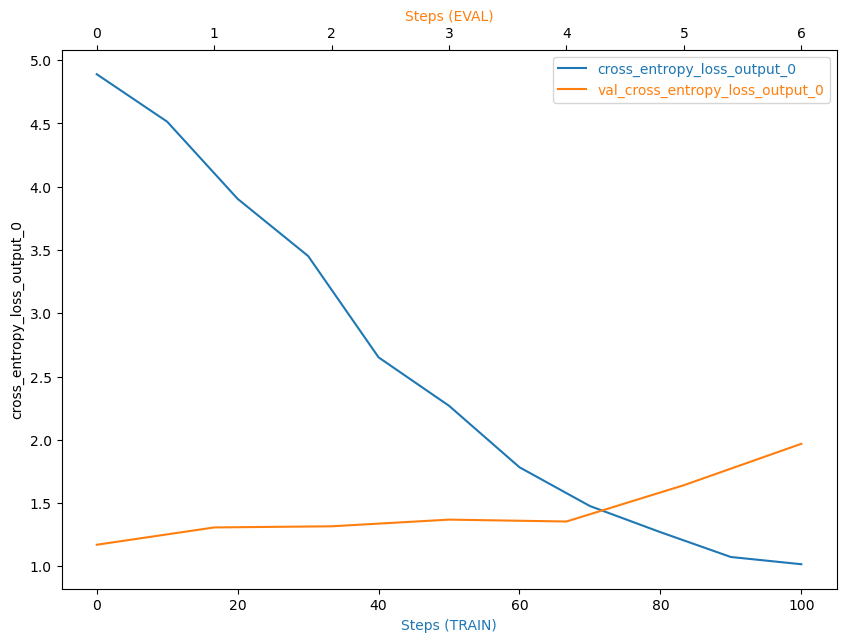

In [24]:
plot_tensor(trial, "cross_entropy_loss_output_0")

**TODO**: Is there some anomalous behaviour in your debugging output? If so, what is the error and how will you fix it?  
As shown in the above plot, the verification cross entropy was creeping up towards the later steps.  The hyperparameter tuning gave the epoch size of 2. So I increased the value to 5 and ran it all over and I have got a plot below, which seems like a better hyperparameter. This led me to believe that hyperparameter tuning needs many trials before settling on final optimal values.

**TODO**: If not, suppose there was an error. What would that error look like and how would you have fixed it?

<img src="screen_captures/cross_entropy_loss_new.jpg">

In [25]:
# TODO: Display the profiler output
rule_output_path = estimator.output_path + estimator.latest_training_job.job_name + "/rule-output"
rule_output_path

's3://sagemaker-us-east-1-982822995001/debugger-dog-breeds-job-2024-11-22-22-29-50-332/rule-output'

In [26]:
! aws s3 ls {rule_output_path} --recursive

2024-11-22 23:08:34     364137 debugger-dog-breeds-job-2024-11-22-22-29-50-332/rule-output/ProfilerReport/profiler-output/profiler-report.html
2024-11-22 23:08:33     210169 debugger-dog-breeds-job-2024-11-22-22-29-50-332/rule-output/ProfilerReport/profiler-output/profiler-report.ipynb
2024-11-22 23:08:28        192 debugger-dog-breeds-job-2024-11-22-22-29-50-332/rule-output/ProfilerReport/profiler-output/profiler-reports/BatchSize.json
2024-11-22 23:08:28        200 debugger-dog-breeds-job-2024-11-22-22-29-50-332/rule-output/ProfilerReport/profiler-output/profiler-reports/CPUBottleneck.json
2024-11-22 23:08:28       2039 debugger-dog-breeds-job-2024-11-22-22-29-50-332/rule-output/ProfilerReport/profiler-output/profiler-reports/Dataloader.json
2024-11-22 23:08:28        127 debugger-dog-breeds-job-2024-11-22-22-29-50-332/rule-output/ProfilerReport/profiler-output/profiler-reports/GPUMemoryIncrease.json
2024-11-22 23:08:28        199 debugger-dog-breeds-job-2024-11-22-22-29-50-332/rule-

In [42]:
! aws s3 cp {rule_output_path} ./ --recursive

download: s3://sagemaker-us-east-1-982822995001/debugger-dog-breeds-job-2024-11-20-21-04-31-915/rule-output/ProfilerReport/profiler-output/profiler-reports/GPUMemoryIncrease.json to ProfilerReport/profiler-output/profiler-reports/GPUMemoryIncrease.json
download: s3://sagemaker-us-east-1-982822995001/debugger-dog-breeds-job-2024-11-20-21-04-31-915/rule-output/ProfilerReport/profiler-output/profiler-reports/CPUBottleneck.json to ProfilerReport/profiler-output/profiler-reports/CPUBottleneck.json
download: s3://sagemaker-us-east-1-982822995001/debugger-dog-breeds-job-2024-11-20-21-04-31-915/rule-output/ProfilerReport/profiler-output/profiler-reports/Dataloader.json to ProfilerReport/profiler-output/profiler-reports/Dataloader.json
download: s3://sagemaker-us-east-1-982822995001/debugger-dog-breeds-job-2024-11-20-21-04-31-915/rule-output/ProfilerReport/profiler-output/profiler-reports/MaxInitializationTime.json to ProfilerReport/profiler-output/profiler-reports/MaxInitializationTime.json
do

In [27]:
import os

# get the autogenerated folder name of profiler report
profiler_report_name = [
    rule["RuleConfigurationName"]
    for rule in estimator.latest_training_job.rule_job_summary()
    if "Profiler" in rule["RuleConfigurationName"]
][0]

In [29]:
import IPython

IPython.display.HTML(filename=profiler_report_name + "/profiler-output/profiler-report.html")

## Model Deploying

In [30]:
model_location = estimator.model_data
model_location

's3://sagemaker-us-east-1-982822995001/debugger-dog-breeds-job-2024-11-22-22-29-50-332/output/model.tar.gz'

In [31]:
from sagemaker.predictor import Predictor
from sagemaker.pytorch import PyTorchModel

In [32]:
jpeg_serializer = sagemaker.serializers.IdentitySerializer("image/jpeg")
json_deserializer = sagemaker.deserializers.JSONDeserializer()


class ImagePredictor(Predictor):
    def __init__(self, endpoint_name, sagemaker_session):
        super(ImagePredictor, self).__init__(
            endpoint_name,
            sagemaker_session=sagemaker_session,
            serializer=jpeg_serializer,
            deserializer=json_deserializer,
        )

In [33]:
model_location=estimator.model_data

pytorch_inference_model = PyTorchModel(
            entry_point="inference.py",
            role=role,
            model_data=model_location,
            framework_version="1.9",
            py_version="py38",
            predictor_cls=ImagePredictor,
)

In [34]:
# TODO: Deploy your model to an endpoint
predictor = pytorch_inference_model.deploy(initial_instance_count=1, instance_type='ml.t2.medium')

INFO:sagemaker:Repacking model artifact (s3://sagemaker-us-east-1-982822995001/debugger-dog-breeds-job-2024-11-22-22-29-50-332/output/model.tar.gz), script artifact (None), and dependencies ([]) into single tar.gz file located at s3://sagemaker-us-east-1-982822995001/pytorch-inference-2024-11-22-23-11-08-744/model.tar.gz. This may take some time depending on model size...
INFO:sagemaker:Creating model with name: pytorch-inference-2024-11-22-23-11-19-330
INFO:sagemaker:Creating endpoint-config with name pytorch-inference-2024-11-22-23-11-20-072
INFO:sagemaker:Creating endpoint with name pytorch-inference-2024-11-22-23-11-20-072


----------------!

In [36]:
from glob import glob
dog_names = [item[20:-1] for item in sorted(glob("dogImages/train/*/"))] 
dog_names[:10]

['Affenpinscher',
 'Afghan_hound',
 'Airedale_terrier',
 'Akita',
 'Alaskan_malamute',
 'American_eskimo_dog',
 'American_foxhound',
 'American_staffordshire_terrier',
 'American_water_spaniel',
 'Anatolian_shepherd_dog']

In [43]:
from PIL import Image
import io
import numpy as np

Display Image:


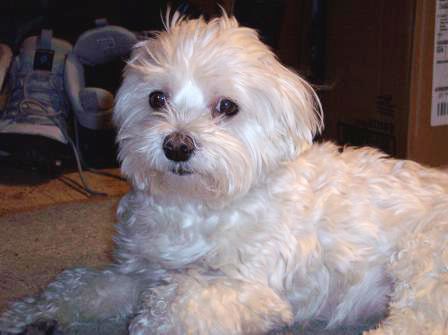

Expected Breed: Maltese
Identified breed: Havanese


Display Image:


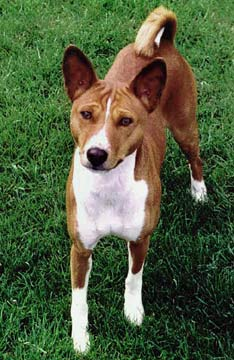

Expected Breed: Basenji
Identified breed: Basenji


Display Image:


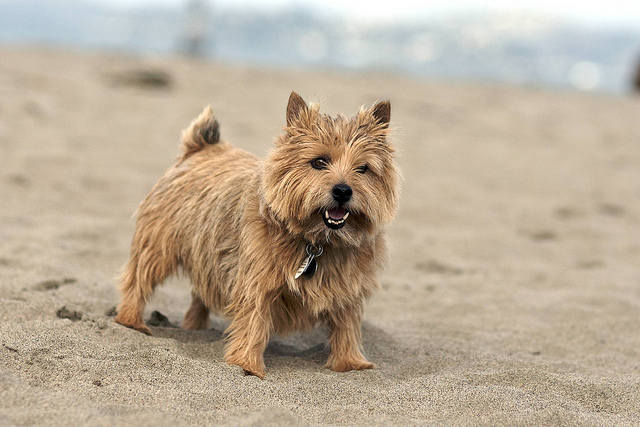

Expected Breed: NorwichTerrier
Identified breed: Norwich_terrier




In [47]:
test_dir = "./data/test/"
test_images = ['Maltese_06716.jpg', 'Basenji_01009.jpg', 'NorwichTerrier_07240.jpg']
expected_breeds = [fname.split("_")[0] for fname in test_images] 
test_images_expected_output = 101

for index in range(len(test_images)):
    
    test_image = test_images[index]
    breed = expected_breeds[index]
    test_file_path = os.path.join(test_dir, test_image) 
    
    with open(test_file_path , "rb") as f:
        payload = f.read()
        print("Display Image:")
        display(Image.open(io.BytesIO(payload)))
        print(f"Expected Breed: {breed}")
        response = predictor.predict(payload, initial_args={"ContentType": "image/jpeg"}) 
        predicted_dog_breed = np.argmax(response, 1) + 1
        #print(f"Inference on class: {predicted_dog_breed} ")
        print(f"Identified breed: {dog_names[predicted_dog_breed[0]-1]}\n\n")

In [46]:
# Get error logs 
client = boto3.client('logs')
response = client.get_log_events(
    logGroupName='/aws/sagemaker/Endpoints/debugger-dog-breeds-job-2024-11-20-21-26-21-431',
    logStreamName='AllTraffic/i-01b0e23828f2decb4',
    startFromHead=True,
)

log_events = response['events']
for each_event in log_events:
    print(each_event['message'])

2024-11-20T22:07:43,805 [INFO ] W-9000-model_1.0 ACCESS_LOG - /169.254.178.2:40392 "GET /ping HTTP/1.1" 200 0
2024-11-20T22:07:43,805 [INFO ] W-9000-model_1.0 TS_METRICS - Requests2XX.Count:1|#Level:Host|#hostname:container-0.local,timestamp:1732138448
2024-11-20T22:07:48,806 [INFO ] W-9000-model_1.0 ACCESS_LOG - /169.254.178.2:40392 "GET /ping HTTP/1.1" 200 0
2024-11-20T22:07:48,807 [INFO ] W-9000-model_1.0 TS_METRICS - Requests2XX.Count:1|#Level:Host|#hostname:container-0.local,timestamp:1732138448
2024-11-20T22:07:53,806 [INFO ] W-9000-model_1.0 ACCESS_LOG - /169.254.178.2:40392 "GET /ping HTTP/1.1" 200 0
2024-11-20T22:07:53,807 [INFO ] W-9000-model_1.0 TS_METRICS - Requests2XX.Count:1|#Level:Host|#hostname:container-0.local,timestamp:1732138448
2024-11-20T22:07:58,805 [INFO ] W-9000-model_1.0 ACCESS_LOG - /169.254.178.2:40392 "GET /ping HTTP/1.1" 200 0
2024-11-20T22:07:58,805 [INFO ] W-9000-model_1.0 TS_METRICS - Requests2XX.Count:1|#Level:Host|#hostname:container-0.local,timestamp

In [ ]:
# TODO: Remember to shutdown/delete your endpoint once your work is done
#predictor.delete_endpoint()